In [1]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import torch
import pandas as pd
import cv2
import numpy as np
import supervision as sv
import matplotlib.pyplot as plt

In [2]:


# DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# MODEL_TYPE = "vit_h"
# CHECKPOINT_PATH = "/root/Master_Thesis/sam/sam_vit_h_4b8939.pth"

In [3]:
# sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
# mask_generator = SamAutomaticMaskGenerator(sam)
# mask_predictor = SamPredictor(sam)

In [4]:
df = pd.read_csv("/root/Master_Thesis/data/dataframes/brain_df_train.csv")

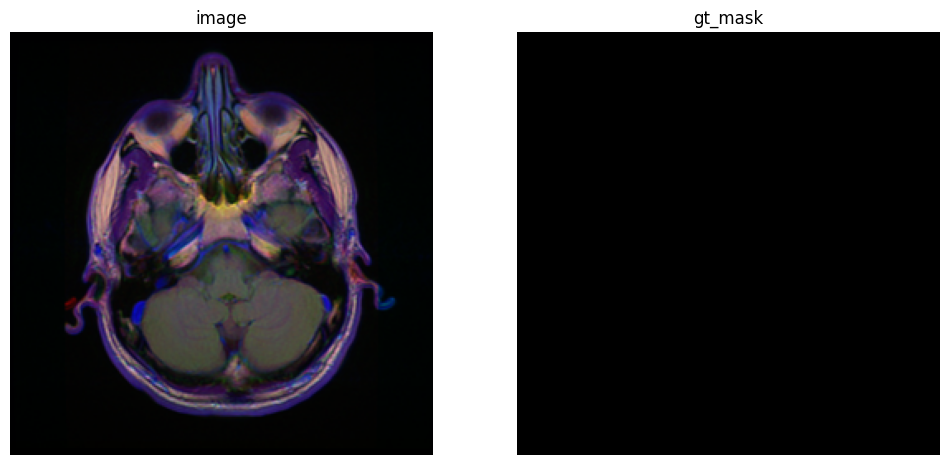

In [31]:
i = np.random.randint(1, len(df))
# masks=[cv2.imread(df["masks"][i]) for i in range(20)]
import supervision as sv

image = cv2.imread(df["images"][i])
gt_mask = cv2.imread(df["masks"][i])
sv.plot_images_grid(
    images=[image, gt_mask],
    # images=masks,
    # grid_size=(1, 20),
    grid_size=(1, 2),
    titles=['image', 'gt_mask']
)

In [32]:
image.transpose(-1, 0, 1)[1].max()

198

In [10]:
type(image[0][0][0])

numpy.uint8

(256, 256)
(256, 256)
image_rgb.shape :  (256, 256, 3)


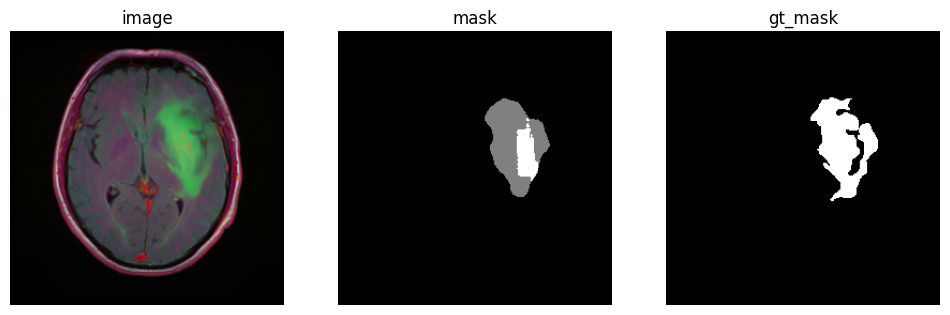

In [9]:
# imgray = cv2.cvtColor(resized_mask, cv2.COLOR_BGR2GRAY)
imgray = cv2.cvtColor(gt_mask, cv2.COLOR_BGR2GRAY)
print(imgray.shape)
ret, thresh = cv2.threshold(imgray, 0.5, 1, 0)
print(thresh.shape)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = []
for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)
    box = np.array([x, y, x+w, y+h])
    cnts.append(box)
    
boxes = np.array(cnts)
boxes = torch.Tensor(boxes).to(DEVICE)
# image_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print("image_rgb.shape : ", image_rgb.shape)

mask_predictor.set_image(image_rgb)
transformed_boxes = mask_predictor.transform.apply_boxes_torch(boxes, image_rgb.shape[:2])


predicted_masks, scores, logits = mask_predictor.predict_torch(
    point_coords = None,
    point_labels = None,
    boxes=transformed_boxes,
    multimask_output=False
)
predicted_mask = predicted_masks.sum(axis = 0).cpu().numpy()

sv.plot_images_grid(
    #images=[image_rgb, mask[0], resized_mask],
    images=[image_rgb, predicted_mask[0], gt_mask],
    grid_size=(1, 3),
    titles=['image', 'mask', 'gt_mask']
)

In [13]:
predicted_mask = torch.as_tensor(predicted_mask).float()
predicted_mask

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [14]:
scores

tensor([[0.9334],
        [0.7835]], device='cuda:1')

In [15]:

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [16]:
# generated_masks = mask_generator.generate(image)
# print(len(generated_masks))
# print(generated_masks[0].keys())
# list_generated_masks=[]
# for mask in generated_masks:
#     list_generated_masks.append(mask["segmentation"])

# sv.plot_images_grid(
#     #images=[image_rgb, mask[0], resized_mask],
#     images=list_generated_masks,
#     grid_size=(1, len(list_generated_masks)),
#     # titles=['image', 'mask', 'gt_mask']
# )

In [17]:
# plt.figure(figsize=(10,10))
# plt.imshow(image)
# show_anns(generated_masks)
# plt.axis('off')
# plt.show() 

In [18]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.90,
    stability_score_thresh=0.70,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [19]:
generated_masks2 = mask_generator_2.generate(image)

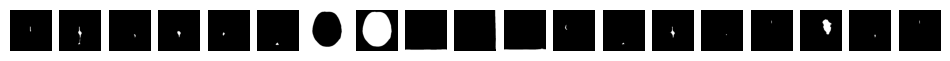

In [20]:
list_generated_masks2=[]
for mask in generated_masks2:
    list_generated_masks2.append(mask["segmentation"])


sv.plot_images_grid(
#images=[image_rgb, mask[0], resized_mask],
images=list_generated_masks2,
grid_size=(1, len(list_generated_masks2)),
# titles=['image', 'mask', 'gt_mask']
)

In [24]:
torch.as_tensor(list_generated_masks2[0]).float()

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [24]:
generated_masks2[0].keys()

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])

In [34]:
generated_masks2[0]["stability_score"]

0.8255033493041992

In [35]:
generated_masks2[15]["stability_score"]

0.8172520995140076

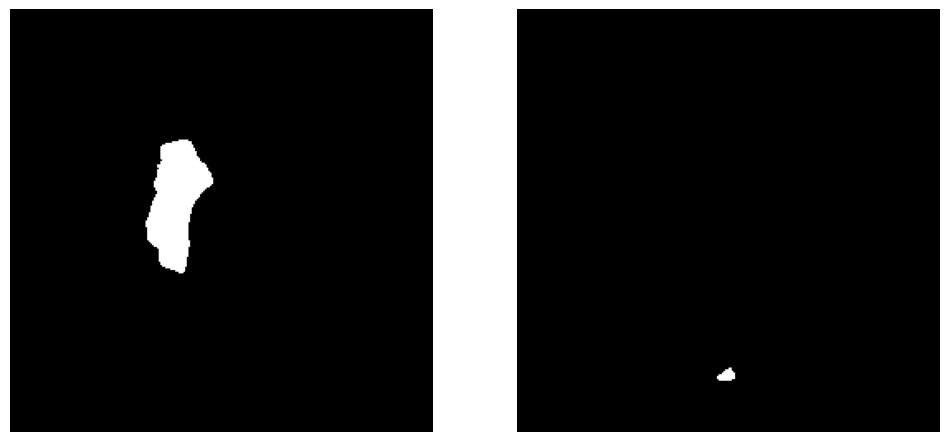

In [23]:
sv.plot_images_grid(
#images=[image_rgb, mask[0], resized_mask],
images=list_generated_masks2[15:17],
grid_size=(1, 2),
# titles=['image', 'mask', 'gt_mask']
)

In [17]:
# plt.figure(figsize=(10,10))
# plt.imshow(image)
# show_anns(generated_masks2[1:2])
# plt.axis('off')
# plt.show() 

In [54]:
print(generated_masks2[0].keys())

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [55]:
generated_masks2[0]["bbox"]

[120, 191, 47, 26]

In [56]:
sor = sorted(generated_masks2, key=(lambda x: x['stability_score']), reverse=True)

In [57]:
sor[0]["bbox"]

[183, 180, 6, 6]